In [161]:
from tensorflow.keras.datasets import fashion_mnist

In [162]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [163]:
from tensorflow import keras
from tensorflow.keras.layers import Dense,Conv2D,Activation,Flatten,MaxPooling2D

In [164]:
! pip install -U keras-tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [165]:
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()

In [166]:
x_train.shape

(60000, 28, 28)

In [167]:
x_train[...,np.newaxis].shape

(60000, 28, 28, 1)

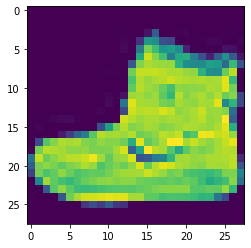

In [168]:
plt.imshow(x_train[0])

In [169]:
x_train = x_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]

In [170]:
x_train.shape[1:]

(28, 28, 1)

In [171]:
def build_model():
  model = keras.Sequential()

  model.add(Conv2D(32,(3,3), input_shape = x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())

  model.add(Dense(10))
  model.add(Activation('softmax'))

  model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model



In [172]:
model = build_model()
history = model.fit(x_train,y_train,batch_size=64,epochs=5, validation_data=(x_test,y_test))

Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 1.8034 - accuracy: 0.7812 - val_loss: 0.7160 - val_accuracy: 0.8153
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.5163 - accuracy: 0.8472 - val_loss: 0.4664 - val_accuracy: 0.8438
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3873 - accuracy: 0.8665 - val_loss: 0.4211 - val_accuracy: 0.8547
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3458 - accuracy: 0.8767 - val_loss: 0.3813 - val_accuracy: 0.8648
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3288 - accuracy: 0.8816 - val_loss: 0.3820 - val_accuracy: 0.8676


## Keras optimizers

In [173]:
LOG_DIR = f"{int(time.time())}"

In [174]:
def build_model_2(hp):
  model = keras.Sequential()

  model.add(Conv2D(hp.Int("input_units",min_value=32,max_value=256,step=32),(3,3), input_shape = x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  for i in range(hp.Int("n_conv_layer",1,15)):
    model.add(Conv2D(hp.Int(f"conv_{i}_units",min_value=16,max_value=256,step=2),(3,3)))
    model.add(Activation('relu'))
    
  model.add(Flatten())

  #for i in range(hp.Int("n_hidden_layer",0,5)):
  #  model.add(Dense(hp.Int(f"hidden_{i}_units",1,50,1)))
  #  model.add(Activation('relu'))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  

  model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model


In [175]:
tuner = RandomSearch(
    build_model_2,
    objective = 'val_accuracy',
    max_trials = 1,
    executions_per_trial = 1,
    directory = LOG_DIR
)

tuner.search(
    x=x_train,
    y=y_train,
    epochs = 5,
    batch_size = 64,
    validation_data = (x_test,y_test)
)

Epoch 1/5
938/938 [==============================] - 6s 6ms/step - loss: 0.6325 - accuracy: 0.7852 - val_loss: 0.4212 - val_accuracy: 0.8517
Epoch 2/5
938/938 [==============================] - 5s 6ms/step - loss: 0.3703 - accuracy: 0.8684 - val_loss: 0.3588 - val_accuracy: 0.8711
Epoch 3/5
938/938 [==============================] - 5s 6ms/step - loss: 0.3247 - accuracy: 0.8819 - val_loss: 0.3453 - val_accuracy: 0.8791
Epoch 4/5
938/938 [==============================] - 5s 6ms/step - loss: 0.2966 - accuracy: 0.8928 - val_loss: 0.3562 - val_accuracy: 0.8774
Epoch 5/5
938/938 [==============================] - 5s 6ms/step - loss: 0.2785 - accuracy: 0.8991 - val_loss: 0.3136 - val_accuracy: 0.8902


INFO:tensorflow:Oracle triggered exit
